# Домашнее задание

* Получить точность 97.5% на валидации MNIST.
* Реализовать морфинг автоэнкодером (без формальных критериев — просто получите красивую гифку).
* Визуализировать MNIST автоэнкодером (обучить автоэнкодер с латентным пространством размерности 2 и вывести через scatter точки разного цвета).

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.cm as cm
%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
torch.manual_seed(42)

#1. Датасет MNIST

In [5]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [6]:
def accuracy(model, val):
    total = 0
    correct = 0
    for X, y in val:
        X = X.view(-1, 784)
        res = model(X)
        res = res.argmax(dim=1)
        total += res.shape[0]
        correct += (res == y).sum().item()
    return correct / total

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.LogSoftmax(dim=1)
)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
criterion = nn.NLLLoss()

EPOCH = 1
TRAIN = 0.894
VAL = 0.896
EPOCH = 2
TRAIN = 0.915
VAL = 0.917
EPOCH = 3
TRAIN = 0.93
VAL = 0.931
EPOCH = 4
TRAIN = 0.937
VAL = 0.934
EPOCH = 5
TRAIN = 0.946
VAL = 0.945
EPOCH = 6
TRAIN = 0.954
VAL = 0.953
EPOCH = 7
TRAIN = 0.959
VAL = 0.955
EPOCH = 8
TRAIN = 0.963
VAL = 0.958
EPOCH = 9
TRAIN = 0.967
VAL = 0.962
EPOCH = 10
TRAIN = 0.97
VAL = 0.964
EPOCH = 11
TRAIN = 0.972
VAL = 0.964
EPOCH = 12
TRAIN = 0.974
VAL = 0.967
EPOCH = 13
TRAIN = 0.978
VAL = 0.968
EPOCH = 14
TRAIN = 0.978
VAL = 0.971
EPOCH = 15
TRAIN = 0.98
VAL = 0.971
EPOCH = 16
TRAIN = 0.98
VAL = 0.971
EPOCH = 17
TRAIN = 0.983
VAL = 0.973
EPOCH = 18
TRAIN = 0.985
VAL = 0.974
EPOCH = 19
TRAIN = 0.985
VAL = 0.974
EPOCH = 20
TRAIN = 0.987
VAL = 0.976
Accuracy = 97.6%


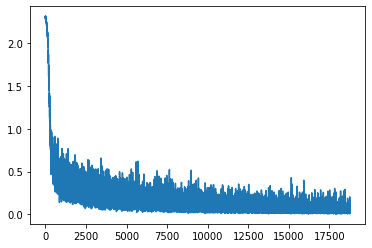

In [ ]:
train_losses = []
for epoch in range(20):
    for X, y in train:
        X = X.view(-1, 784)  # разгладим картинку в вектор

        optimizer.zero_grad()

        output = model(X)
        loss = criterion(output, y)
        loss.backward()

        train_losses.append(loss.item())
        optimizer.step()

    val_accuracy = round(accuracy(model, val), 3)
    print(f"EPOCH = {epoch + 1}")
    print(f"TRAIN = {round(accuracy(model, train), 3)}")
    print(f"VAL = {val_accuracy}")
print(f"Accuracy = {val_accuracy * 100}%")

plt.plot(train_losses)
plt.show()

#2. Морфинг

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size=3):
        super().__init__()
        self.latent_size = latent_size
        
        self.encode = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 12), 
            nn.ReLU(), 
            nn.Linear(12, self.latent_size)
        )
        
        self.decode = nn.Sequential(
            nn.Linear(self.latent_size, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

model = Autoencoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model.forward(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0616
epoch 1, loss 0.0462
epoch 2, loss 0.0411
epoch 3, loss 0.0390
epoch 4, loss 0.0377
epoch 5, loss 0.0367
epoch 6, loss 0.0360
epoch 7, loss 0.0355
epoch 8, loss 0.0350
epoch 9, loss 0.0346


In [9]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

In [10]:
def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

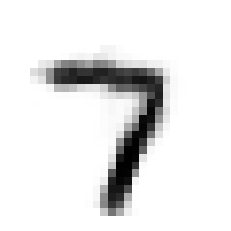

In [11]:
morph(np.random.randint(0, len(train.dataset), 30), 20, 30)

#3. Визуализация MNIST

In [12]:
model = Autoencoder(latent_size=2)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0606
epoch 1, loss 0.0501
epoch 2, loss 0.0466
epoch 3, loss 0.0442
epoch 4, loss 0.0429
epoch 5, loss 0.0420
epoch 6, loss 0.0414
epoch 7, loss 0.0409
epoch 8, loss 0.0404
epoch 9, loss 0.0399


In [14]:
scatter_x = []
scatter_y = []
labels = []
plt_colors = cm.rainbow(np.linspace(0, 1, 10))

for X, label in train:
  X = X.view(-1, 784)
  for elem in model.encode(X).data:
    scatter_x.append(elem.numpy()[0])
    scatter_y.append(elem.numpy()[1])
  labels += [plt_colors[elem.numpy()] for elem in label]

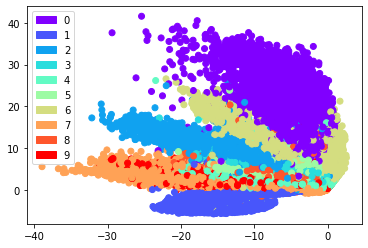

In [15]:
handles = [Patch(color=j, label=str(i)) for i, j in enumerate(plt_colors)]
plt.legend(handles=handles)
plt.scatter(scatter_x, scatter_y, c=labels)
plt.show()